# Pendulum
## Install Requirements

In [1]:
!conda install -y control slycot

Solving environment: done

# All requested packages already installed.



## Simple Pendulum

In [2]:
import sympy

# declare symbols
t = sympy.symbols('t')

x = sympy.Function('x')(t)
y = sympy.Function('y')(t)
θ = sympy.Function('θ')(t)

m, l, g = sympy.symbols('m l g')
θ_dot = θ.diff(t)

θ_dot

Derivative(θ(t), t)

In [3]:
L_tb = (m / 2) * l**2 * θ_dot**2 - m * g * l * sympy.cos(θ)
L = L_tb

L

-g*l*m*cos(θ(t)) + l**2*m*Derivative(θ(t), t)**2/2

In [4]:
f_θ = θ_dot

L_θ = sympy.diff(sympy.diff(L, sympy.diff(θ, t)), t) - sympy.diff(L, θ)
f_dθ = sympy.solve(L_θ, θ.diff(t, t))[0]

f_dθ

g*sin(θ(t))/l

In [5]:
states = [θ, θ.diff(t)]
eqs = [f_θ, f_dθ]

In [6]:
def createMatrix(eqs: list, states: list) -> sympy.Matrix:
    if (len(eqs) != len(states)):
        print("eqs and states must have the same size")
    A = sympy.zeros(len(eqs), len(eqs))
    for i, eq in enumerate(eqs, start=0):
        for j, state in enumerate(states, start=0):
            A[i, j] = sympy.diff(eq, state)
    return A

In [7]:
A = createMatrix(eqs, states)

A

Matrix([
[            0, 1],
[g*cos(θ(t))/l, 0]])

In [8]:
b = sympy.symbols('b') # b = {-1, 1}

linearice = [
    (sympy.sin(θ), 0),
    (sympy.cos(θ), b),
    (θ.diff(t, t), 0),
    (θ.diff(t), 0)
]

constants = [
    (m, 10),
    (g, 9.81),
    (l, 2)
]

A_lin_c = A.subs(linearice).subs(constants)

A_lin_c

Matrix([
[      0, 1],
[4.905*b, 0]])

In [9]:
import numpy as np

A_j_up = np.float64(sympy.simplify(A_lin_c.subs([(b, 1)])))
A_j_down = np.float64(sympy.simplify(A_lin_c.subs([(b, -1)])))

In [10]:
sympy.Matrix(A_j_up)

Matrix([
[  0.0, 1.0],
[4.905, 0.0]])

In [11]:
sympy.Matrix(A_j_down)

Matrix([
[   0.0, 1.0],
[-4.905, 0.0]])

In [12]:
import control
import numpy.linalg as linalg

B = np.float64(sympy.Matrix([0, 1]))

C_up = control.ctrb(A_j_up, B)
C_down = control.ctrb(A_j_down, B)

rank_up = linalg.matrix_rank(C_up)
rank_down = linalg.matrix_rank(C_down)

print("Rank up:   " + str(rank_up))
print("Rank down: " + str(rank_down))

Rank up:   2
Rank down: 2


In [13]:
sympy.Matrix(control.obsv(A_j_up, C_up))

Matrix([
[  0.0, 1.0],
[  1.0, 0.0],
[4.905, 0.0],
[  0.0, 1.0]])

In [14]:
sympy.Matrix(control.obsv(A_j_down, C_down))

Matrix([
[   0.0, 1.0],
[   1.0, 0.0],
[-4.905, 0.0],
[   0.0, 1.0]])

In [15]:
Q = np.float64(np.diag([1, 1]))
R = np.float64(sympy.Matrix([0.1]))

sympy.Matrix(Q)

Matrix([
[1.0, 0.0],
[0.0, 1.0]])

In [16]:
print("A_down: " + str(A_j_down.shape) + ", A_up: " + str(A_j_up.shape) + ", B: " + str(B.shape) + ", Q: " + str(Q.shape) + ", R: " + str(R.shape))

A_down: (2, 2), A_up: (2, 2), B: (2, 1), Q: (2, 2), R: (1, 1)


## Generate LQR Controller

In [17]:
K, S, E = control.lqr(A_j_up, B, Q, R)

K_up = np.float64(K)

sympy.Matrix(K_up)

Matrix([[10.74101105208, 5.61088425332051]])

In [18]:
K, S, E = control.lqr(A_j_down, B, Q, R)

K_down = np.float64(K)

sympy.Matrix(K_down)

Matrix([[0.931011052080011, 3.44412864221998]])

## Simulation

In [19]:
import math

offset = 0.4
θ_up_0 = offset
θ_down_0 = math.pi + offset

In [20]:
import scipy.integrate as integrate

dt = 0.01
timeline = np.arange(0., 10., dt)

def apply(y, t):
    return A_local.dot(y)

A_local = A_j_up
x_0 = np.float64([θ_up_0, 0.0])

solution_up_lin = integrate.odeint(apply, x_0, timeline)

A_local = A_j_down
x_0 = np.float64([θ_down_0, 0.0])

solution_down_lin = integrate.odeint(apply, x_0, timeline)

In [21]:
f_dθ_c = f_dθ.subs(constants)

f_dθ_c

4.905*sin(θ(t))

In [22]:
def apply_deq(y, t):
    ret = np.zeros(2)
    ret[0] = y[1]
    ret[1] = f_dθ_c.subs([(θ, y[0])])
    return ret

x_0 = np.float64([θ_up_0, 0.0])

solution_up_deq = integrate.odeint(apply_deq, x_0, timeline)

x_0 = np.float64([θ_down_0, 0.0])

solution_down_deq = integrate.odeint(apply_deq, x_0, timeline)

Uncontrolled Pendulum


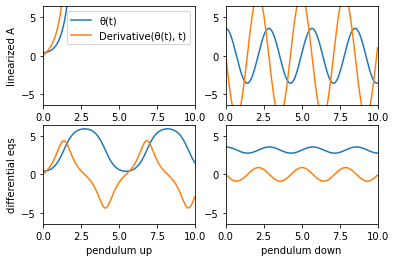

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])


axs[0,0].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Uncontrolled Pendulum")

In [24]:
import scipy.integrate as integrate

dt = 0.01
timeline = np.arange(0., 10., dt)

def apply(y_k, t):
    BK = B * K
    # Seems to be a wired bug
    BK = np.float64([[BK[0,0],BK[0,1]],[BK[1,0],BK[1,1]]])
    retK = np.float64(BK) @ y_k
    return A_local.dot(y_k) - retK

A_local = A_j_up
x_0 = np.float64([θ_up_0, 0.0])
K = K_up

solution_up_lin_k = integrate.odeint(apply, x_0, timeline)

A_local = A_j_down
x_0 = np.float64([θ_down_0, 0.0])
K = K_down

solution_down_lin_k = integrate.odeint(apply, x_0, timeline)

In [25]:
def apply_deq(y_k, t):
    ret = np.zeros(2)
    retA = np.zeros(2)
    retK = np.zeros(2)
    
    retA[0] = y_k[1]
    retA[1] = f_dθ_c.subs([(θ, y_k[0])])
    
    BK = B * K
    
    # Seems to be a wired bug
    BK = np.float64([[BK[0,0],BK[0,1]],[BK[1,0],BK[1,1]]])
    retK = np.float64(BK) @ (y_k)
    return retA - retK

x_0 = np.float64([θ_up_0, 0.0])
K = K_up

solution_up_deq_k = integrate.odeint(apply_deq, x_0, timeline)

x_0 = np.float64([θ_down_0, 0.0])
K = K_down

solution_down_deq_k = integrate.odeint(apply_deq, x_0, timeline)

Controlled Pendulum


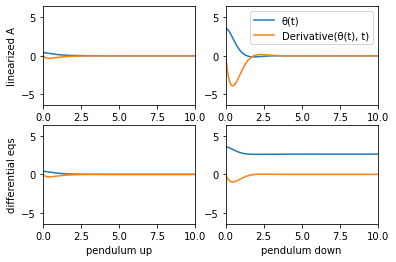

In [26]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Controlled Pendulum")

Controlled Pendulum (Zoom)


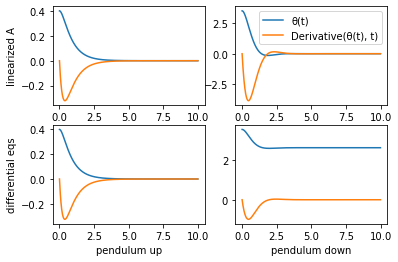

In [27]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.plot()

print("Controlled Pendulum (Zoom)")